# 02 - Volatility Estimation
## Risk Parity Portfolio Project

**Objective**: Estimate asset volatility and correlation structure

### Sections:
1. Calculate rolling volatility (60-day window)
2. Estimate covariance matrix
3. Analyze correlation structure
4. Visualize volatility patterns

In [10]:
# Imports
import sys
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src.data_loader import DataLoader
from src.risk_models import RiskModels
from src.visualization import PortfolioVisualizer

import warnings
warnings.filterwarnings('ignore')

plt.style.use('dark_background')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## 1. Load Data

In [16]:
# Load saved price data
loader = DataLoader(fred_api_key="9fb3507ccba20e766e4972a45c57c18c")
prices = loader.load_data('../data/raw_prices.csv')

# Calculate returns
returns = RiskModels.calculate_returns(prices, method='log')

print(f"Data loaded: {returns.shape[0]} days, {returns.shape[1]} assets")


📂 Loaded cached data → (2567, 3)
Data loaded: 2566 days, 3 assets


## 2. Rolling Volatility Estimation

In [18]:
# Calculate 60-day rolling volatility
rolling_vol = RiskModels.calculate_rolling_volatility(returns, window=60)

print("\n📊 Rolling Volatility Statistics:")
print(rolling_vol.describe())


📊 Rolling Volatility Statistics:
            Stocks        Bonds  Commodities
count  2507.000000  2507.000000  2507.000000
mean      0.153786     0.366226     0.101676
std       0.093440     0.270454     0.156287
min       0.048139     0.110305     0.000000
25%       0.101186     0.209920     0.000000
50%       0.125902     0.276685     0.032282
75%       0.174834     0.439153     0.160323
max       0.636603     1.849674     0.743562


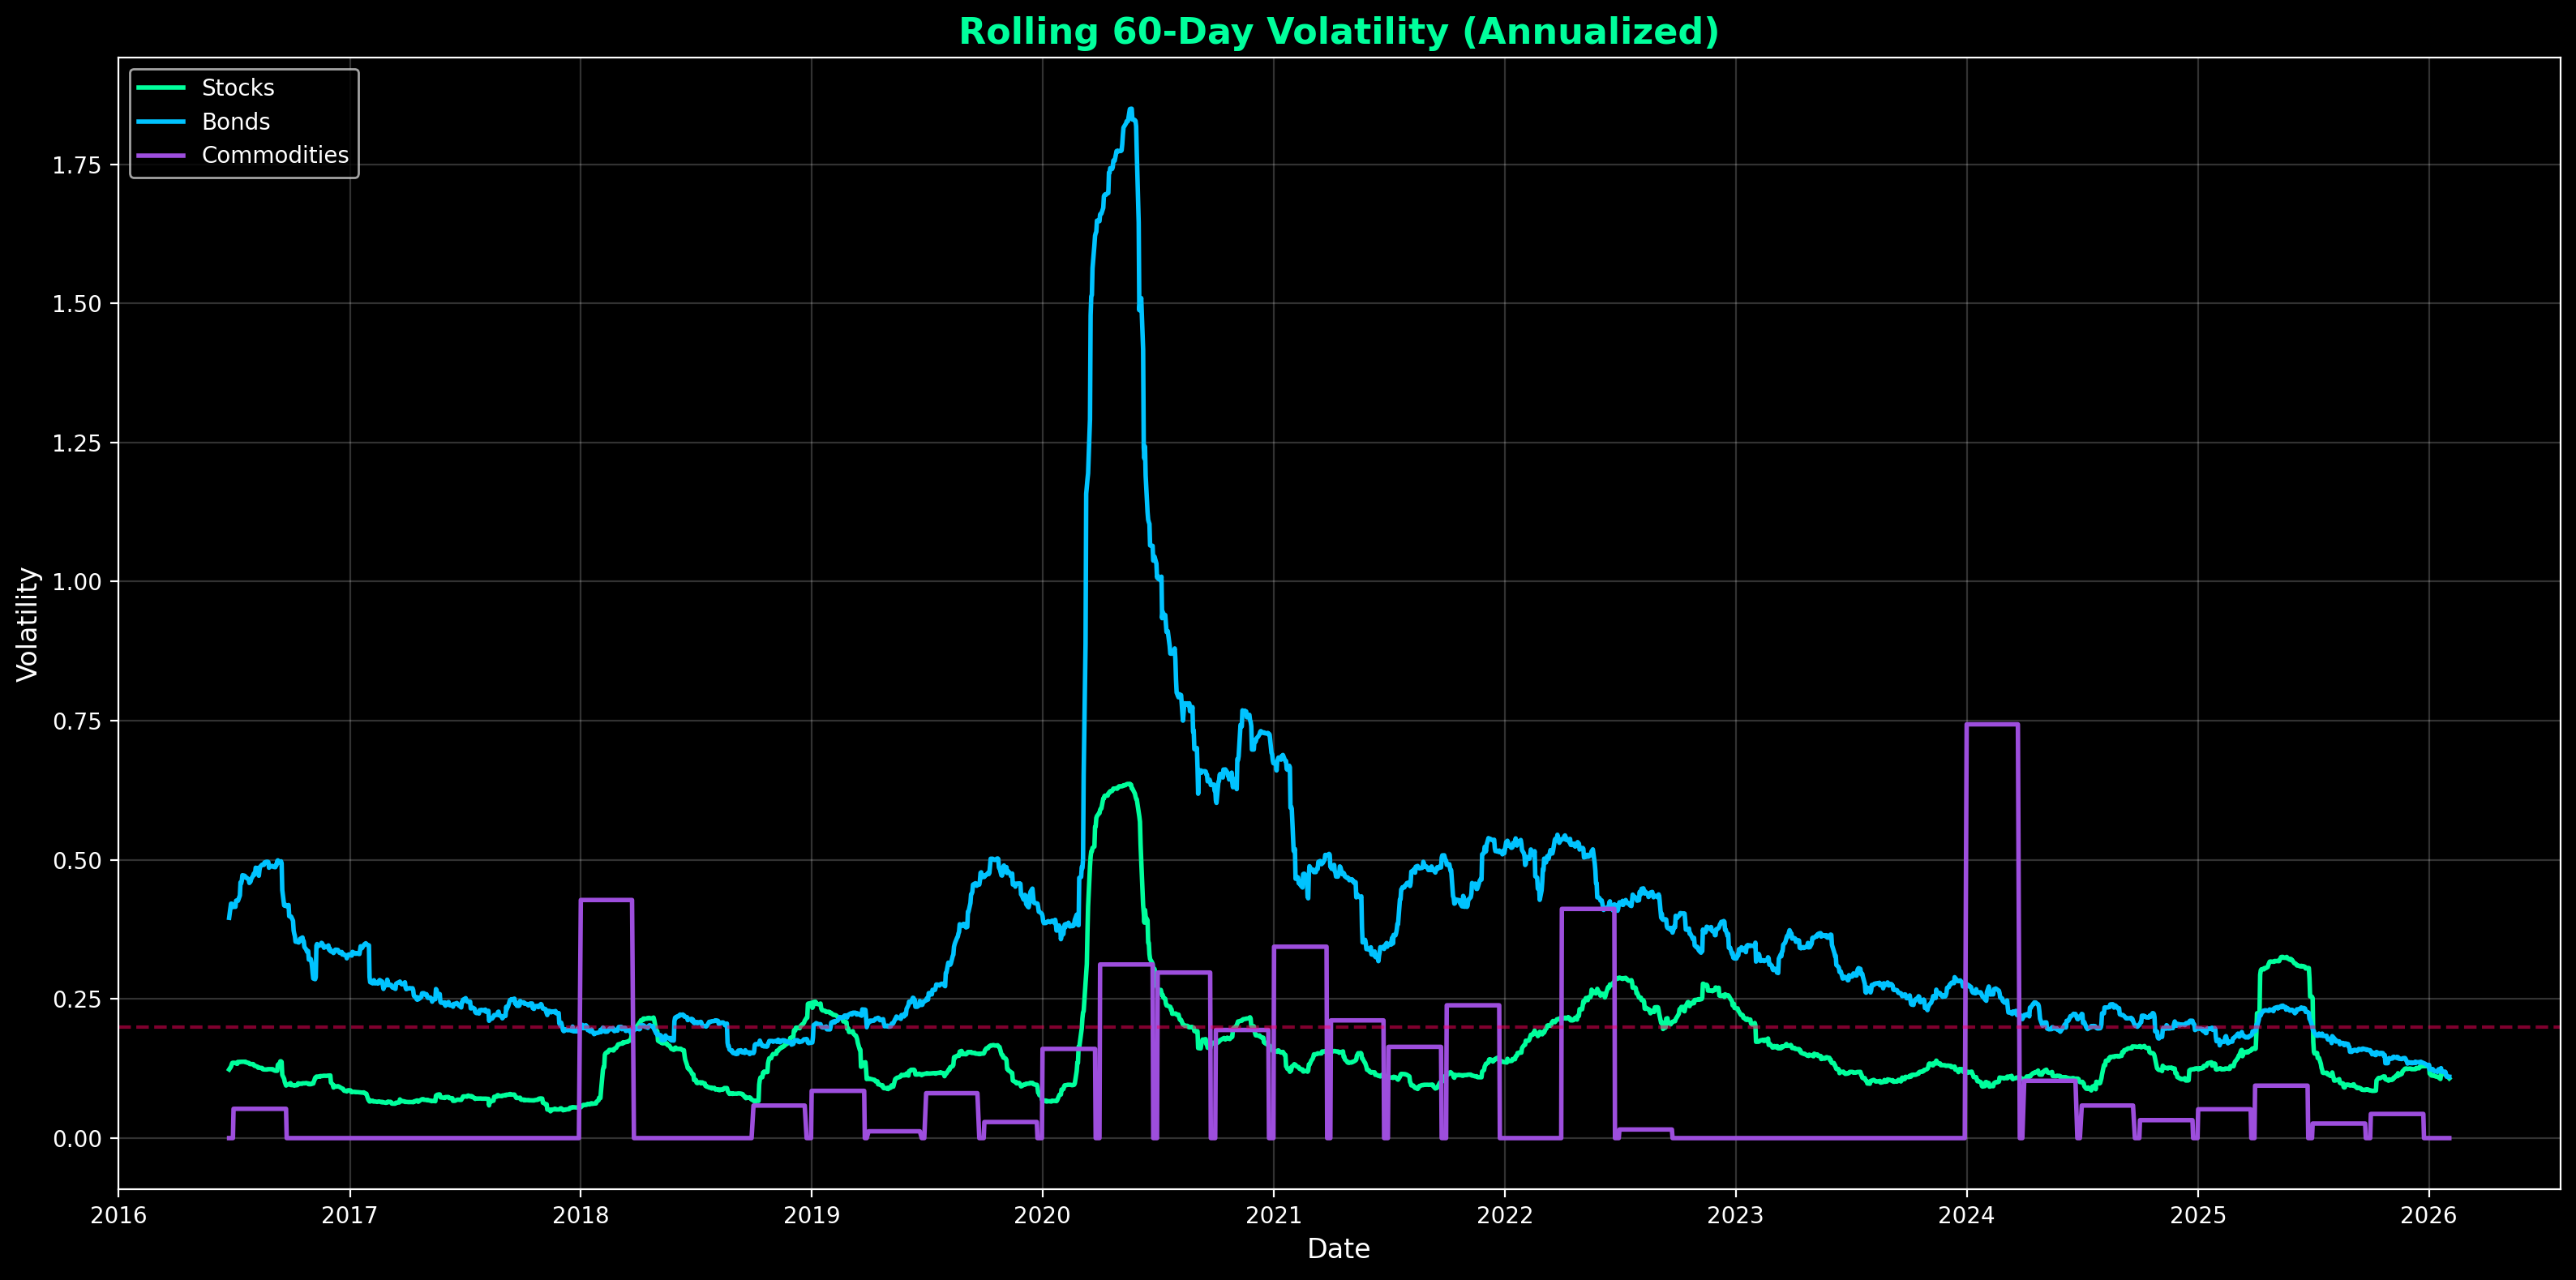

In [20]:
# Plot rolling volatility
viz = PortfolioVisualizer()
fig = viz.plot_rolling_volatility(rolling_vol, figsize=(16, 8))
plt.show()

## 3. Volatility During Key Periods

In [22]:
# Define crisis periods
crisis_periods = {
    'GFC': ('2008-09-01', '2009-03-31'),
    'COVID': ('2020-02-01', '2020-04-30'),
    'Inflation Shock': ('2022-01-01', '2022-12-31')
}

# Calculate average volatility during each period
crisis_vol = {}

for crisis_name, (start, end) in crisis_periods.items():
    period_vol = rolling_vol.loc[start:end].mean()
    crisis_vol[crisis_name] = period_vol

crisis_vol_df = pd.DataFrame(crisis_vol)
print("\n📈 Average Volatility During Crises:")
print(crisis_vol_df.round(4))


📈 Average Volatility During Crises:
             GFC   COVID  Inflation Shock
Stocks       NaN  0.3902           0.2301
Bonds        NaN  1.1348           0.4439
Commodities  NaN  0.1999           0.0986


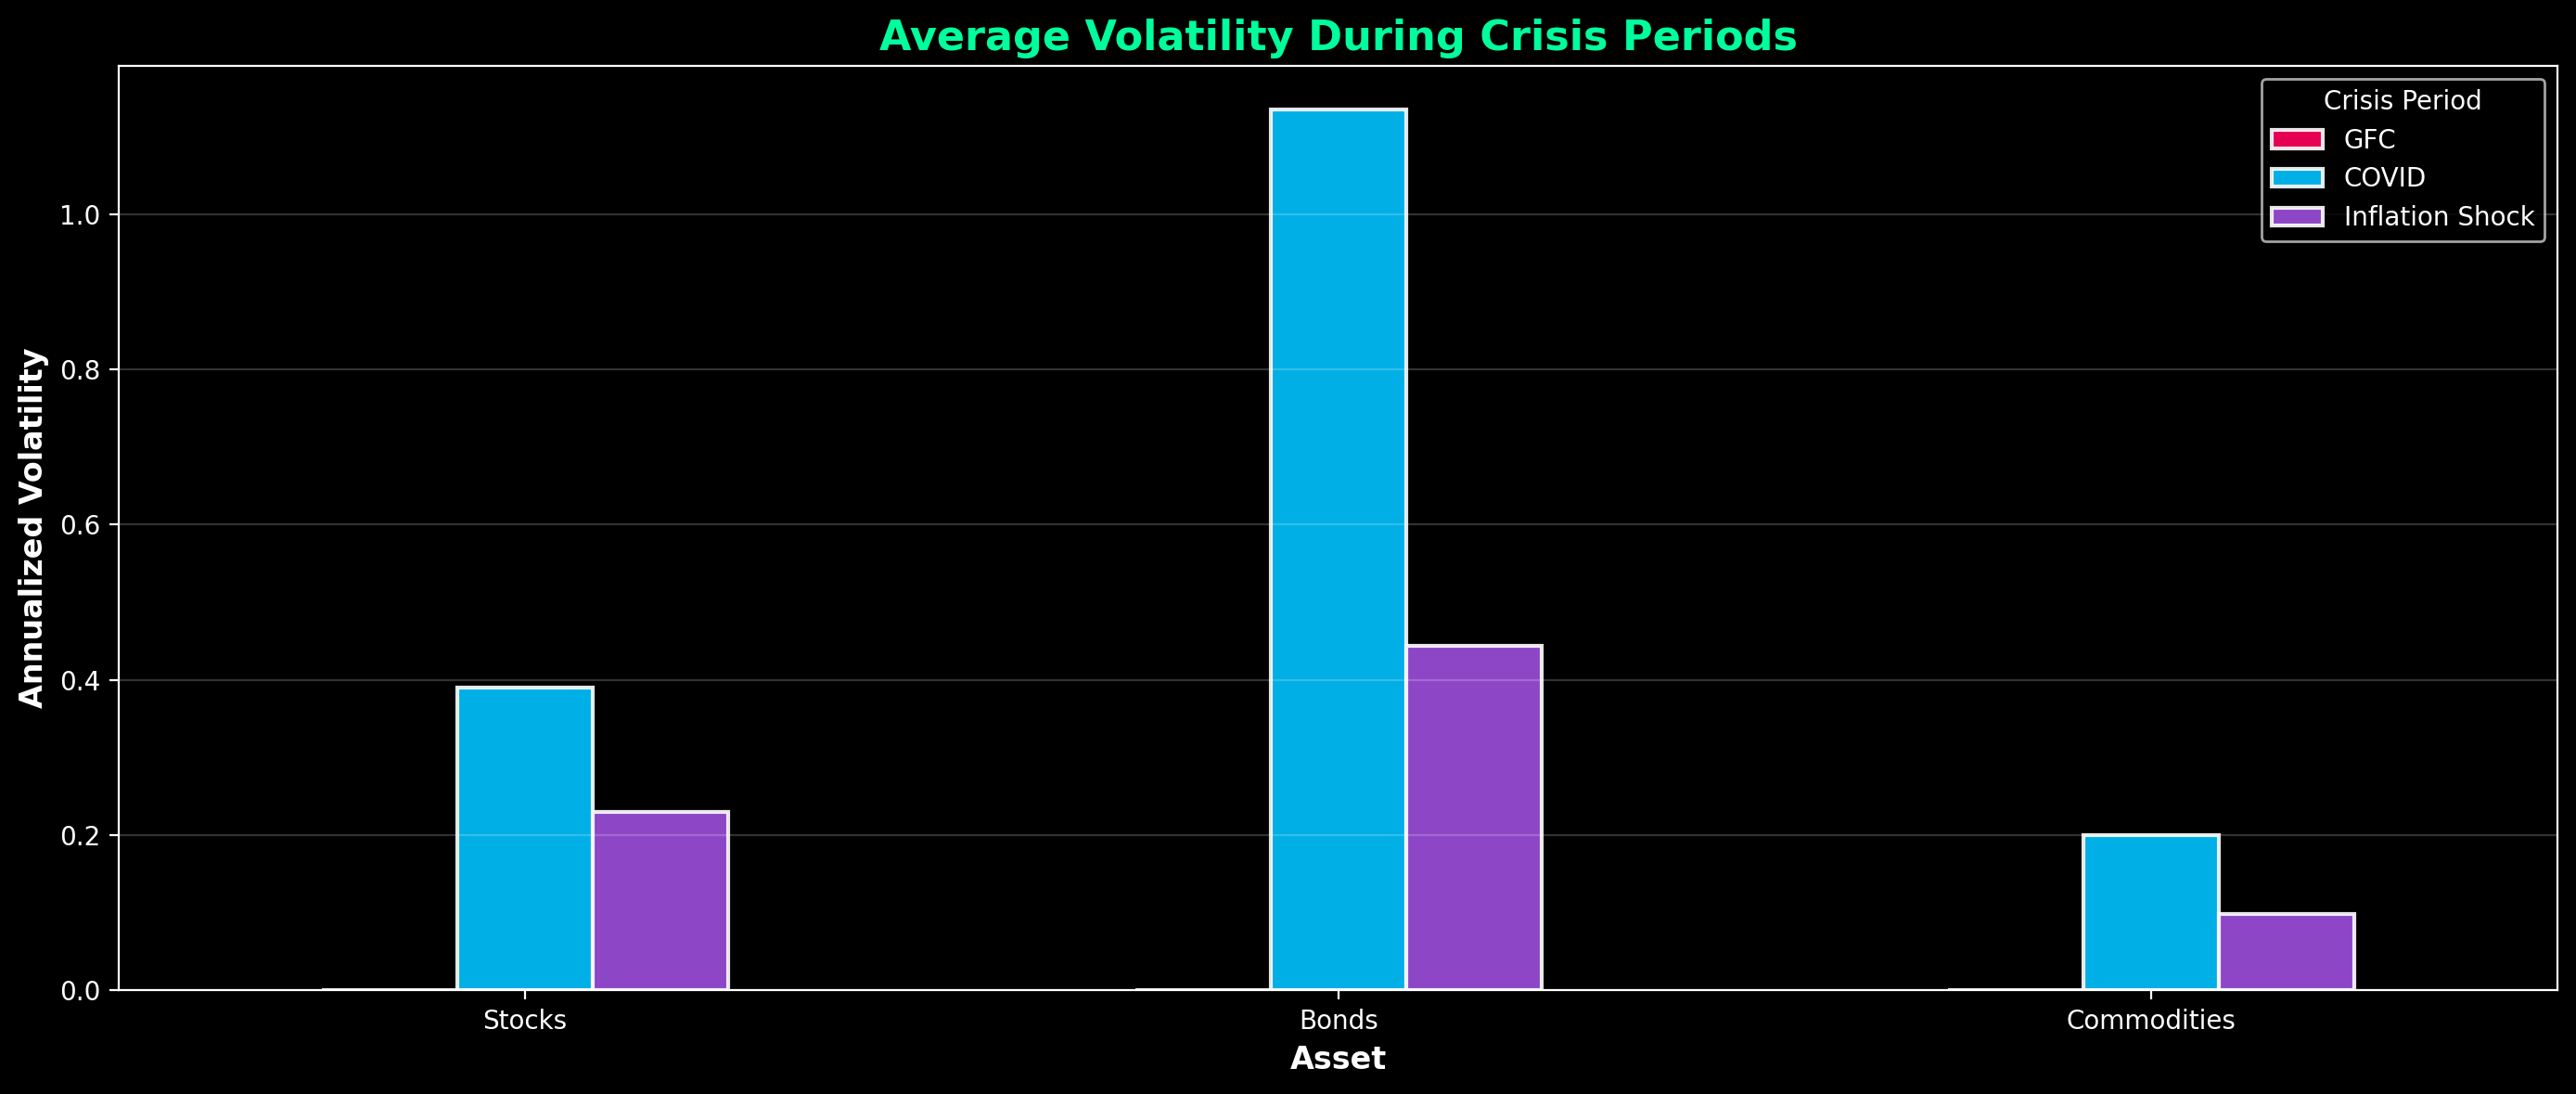

In [24]:
# Visualize crisis volatility
STONKS_GREEN = '#00ff9c'
STONKS_RED = '#ff005c'
STONKS_BLUE = '#00c3ff'

fig, ax = plt.subplots(figsize=(14, 6))

crisis_vol_df.plot(kind='bar', ax=ax, 
                   color=[STONKS_RED, STONKS_BLUE, '#9d4edd'],
                   edgecolor='white', linewidth=1.5, alpha=0.9)

ax.set_title('Average Volatility During Crisis Periods', 
            fontsize=16, fontweight='bold', color=STONKS_GREEN)
ax.set_xlabel('Asset', fontsize=12, fontweight='bold')
ax.set_ylabel('Annualized Volatility', fontsize=12, fontweight='bold')
ax.legend(title='Crisis Period', framealpha=0.8)
ax.grid(True, alpha=0.2, axis='y')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## 4. Covariance Matrix

In [26]:
# Calculate full-sample covariance matrix
cov_matrix = RiskModels.calculate_covariance_matrix(returns)

print("\n📊 Annualized Covariance Matrix:")
cov_df = pd.DataFrame(cov_matrix, 
                     index=returns.columns, 
                     columns=returns.columns)
print(cov_df.round(4))


📊 Annualized Covariance Matrix:
             Stocks   Bonds  Commodities
Stocks       0.0317  0.0226       0.0010
Bonds        0.0226  0.2039       0.0024
Commodities  0.0010  0.0024       0.0340


## 5. Correlation Analysis

In [28]:
# Calculate correlation matrix
corr_matrix = RiskModels.calculate_correlation_matrix(returns)

print("\n📊 Correlation Matrix:")
print(corr_matrix.round(3))


📊 Correlation Matrix:
             Stocks  Bonds  Commodities
Stocks        1.000  0.281        0.032
Bonds         0.281  1.000        0.028
Commodities   0.032  0.028        1.000


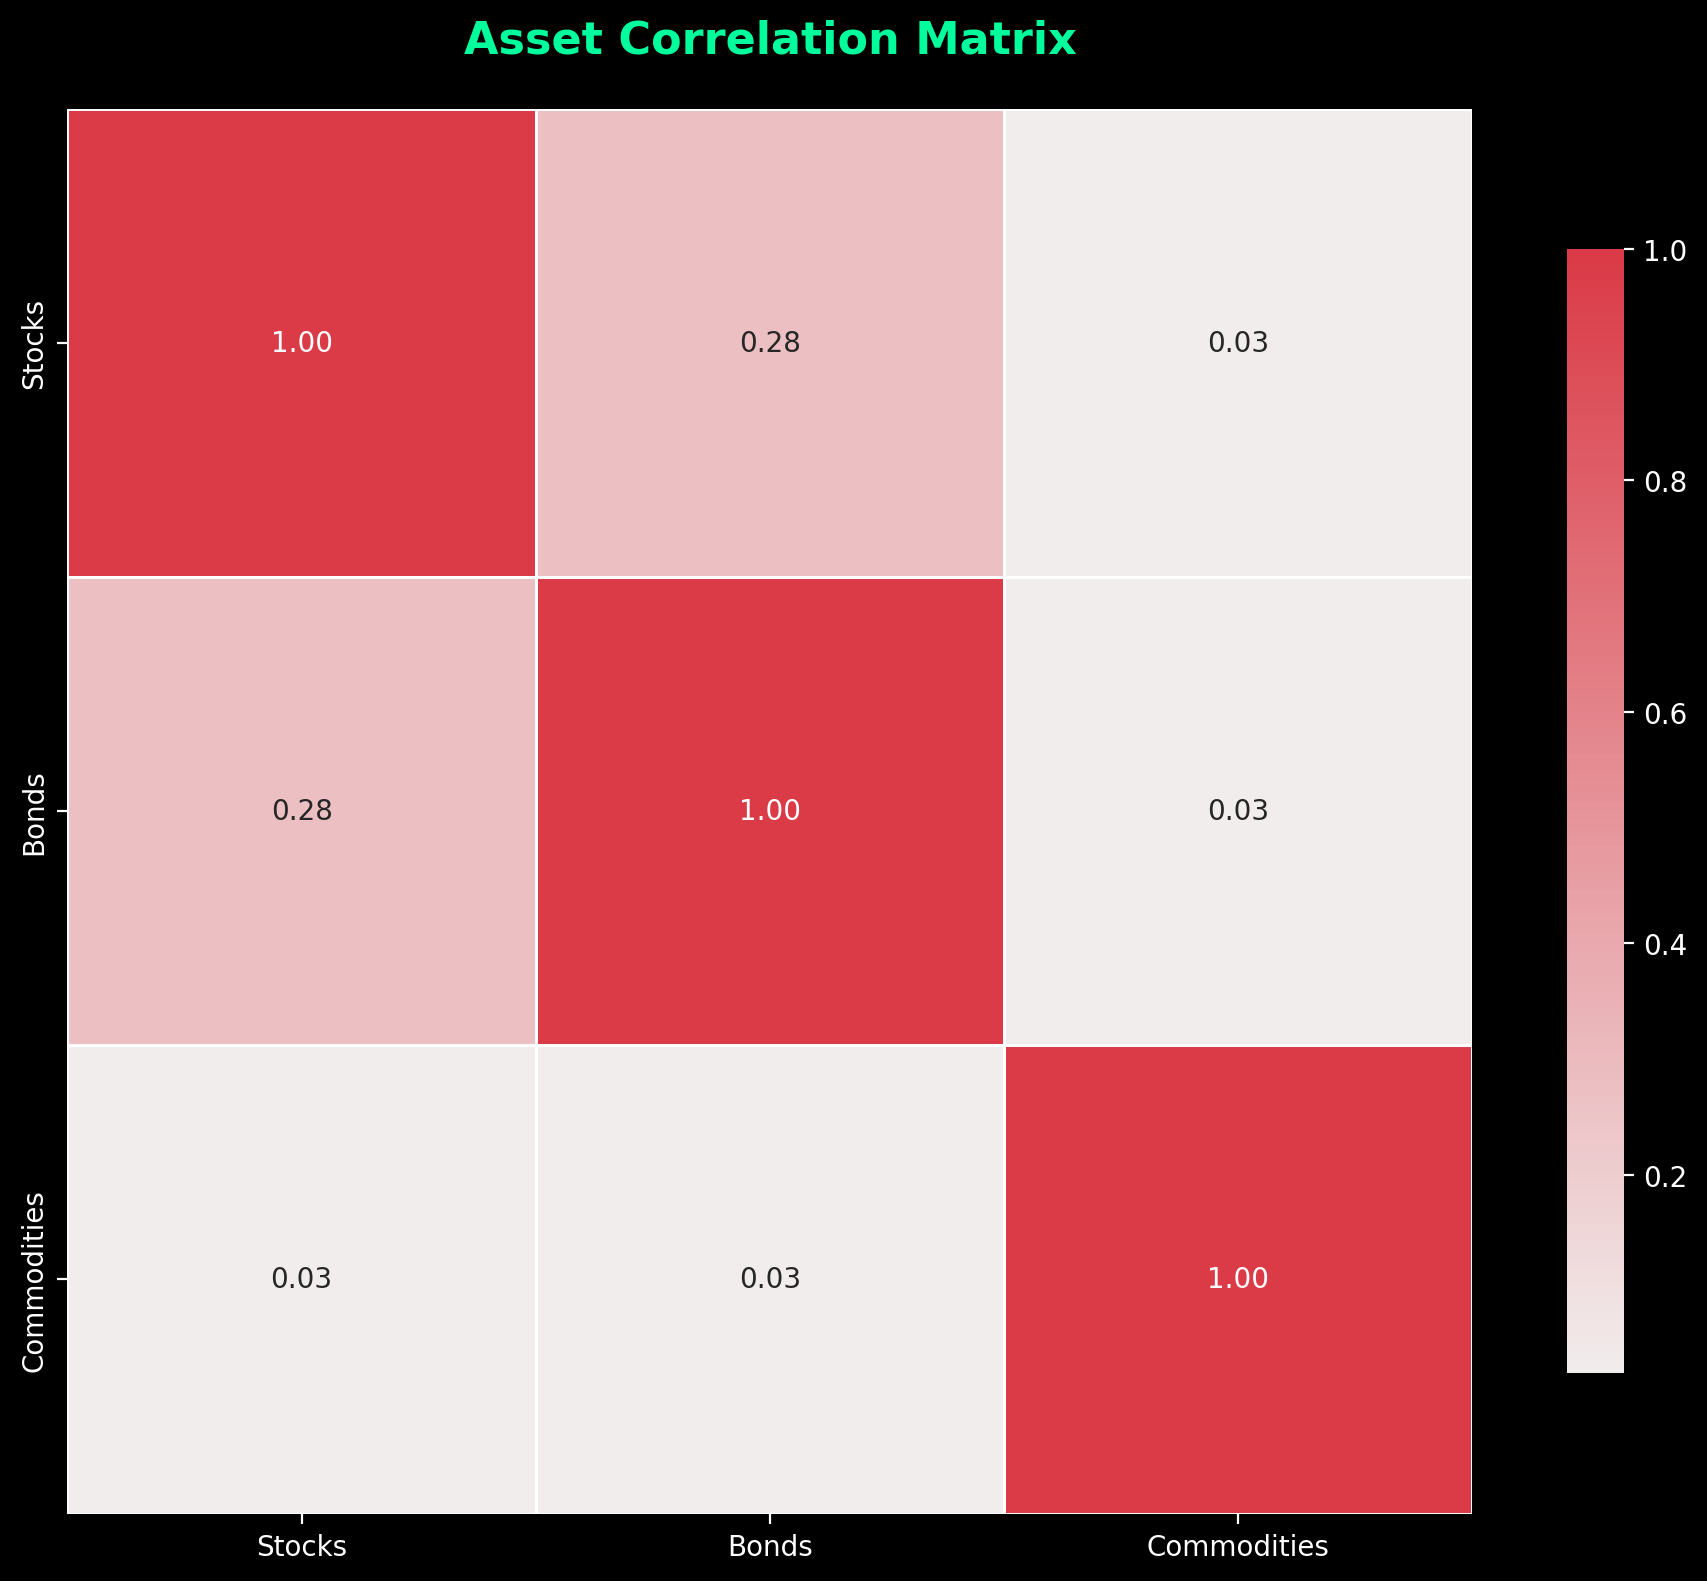

In [30]:
# Visualize correlation heatmap
fig = viz.plot_correlation_heatmap(corr_matrix, figsize=(10, 8))
plt.show()

## 6. Asset Volatility Comparison

In [32]:
# Calculate historical volatility (full sample)
historical_vol = returns.std() * np.sqrt(252)

print("\n📊 Historical Annualized Volatility:")
print(historical_vol.sort_values(ascending=False).round(4))


📊 Historical Annualized Volatility:
Bonds          0.4515
Commodities    0.1843
Stocks         0.1779
dtype: float64


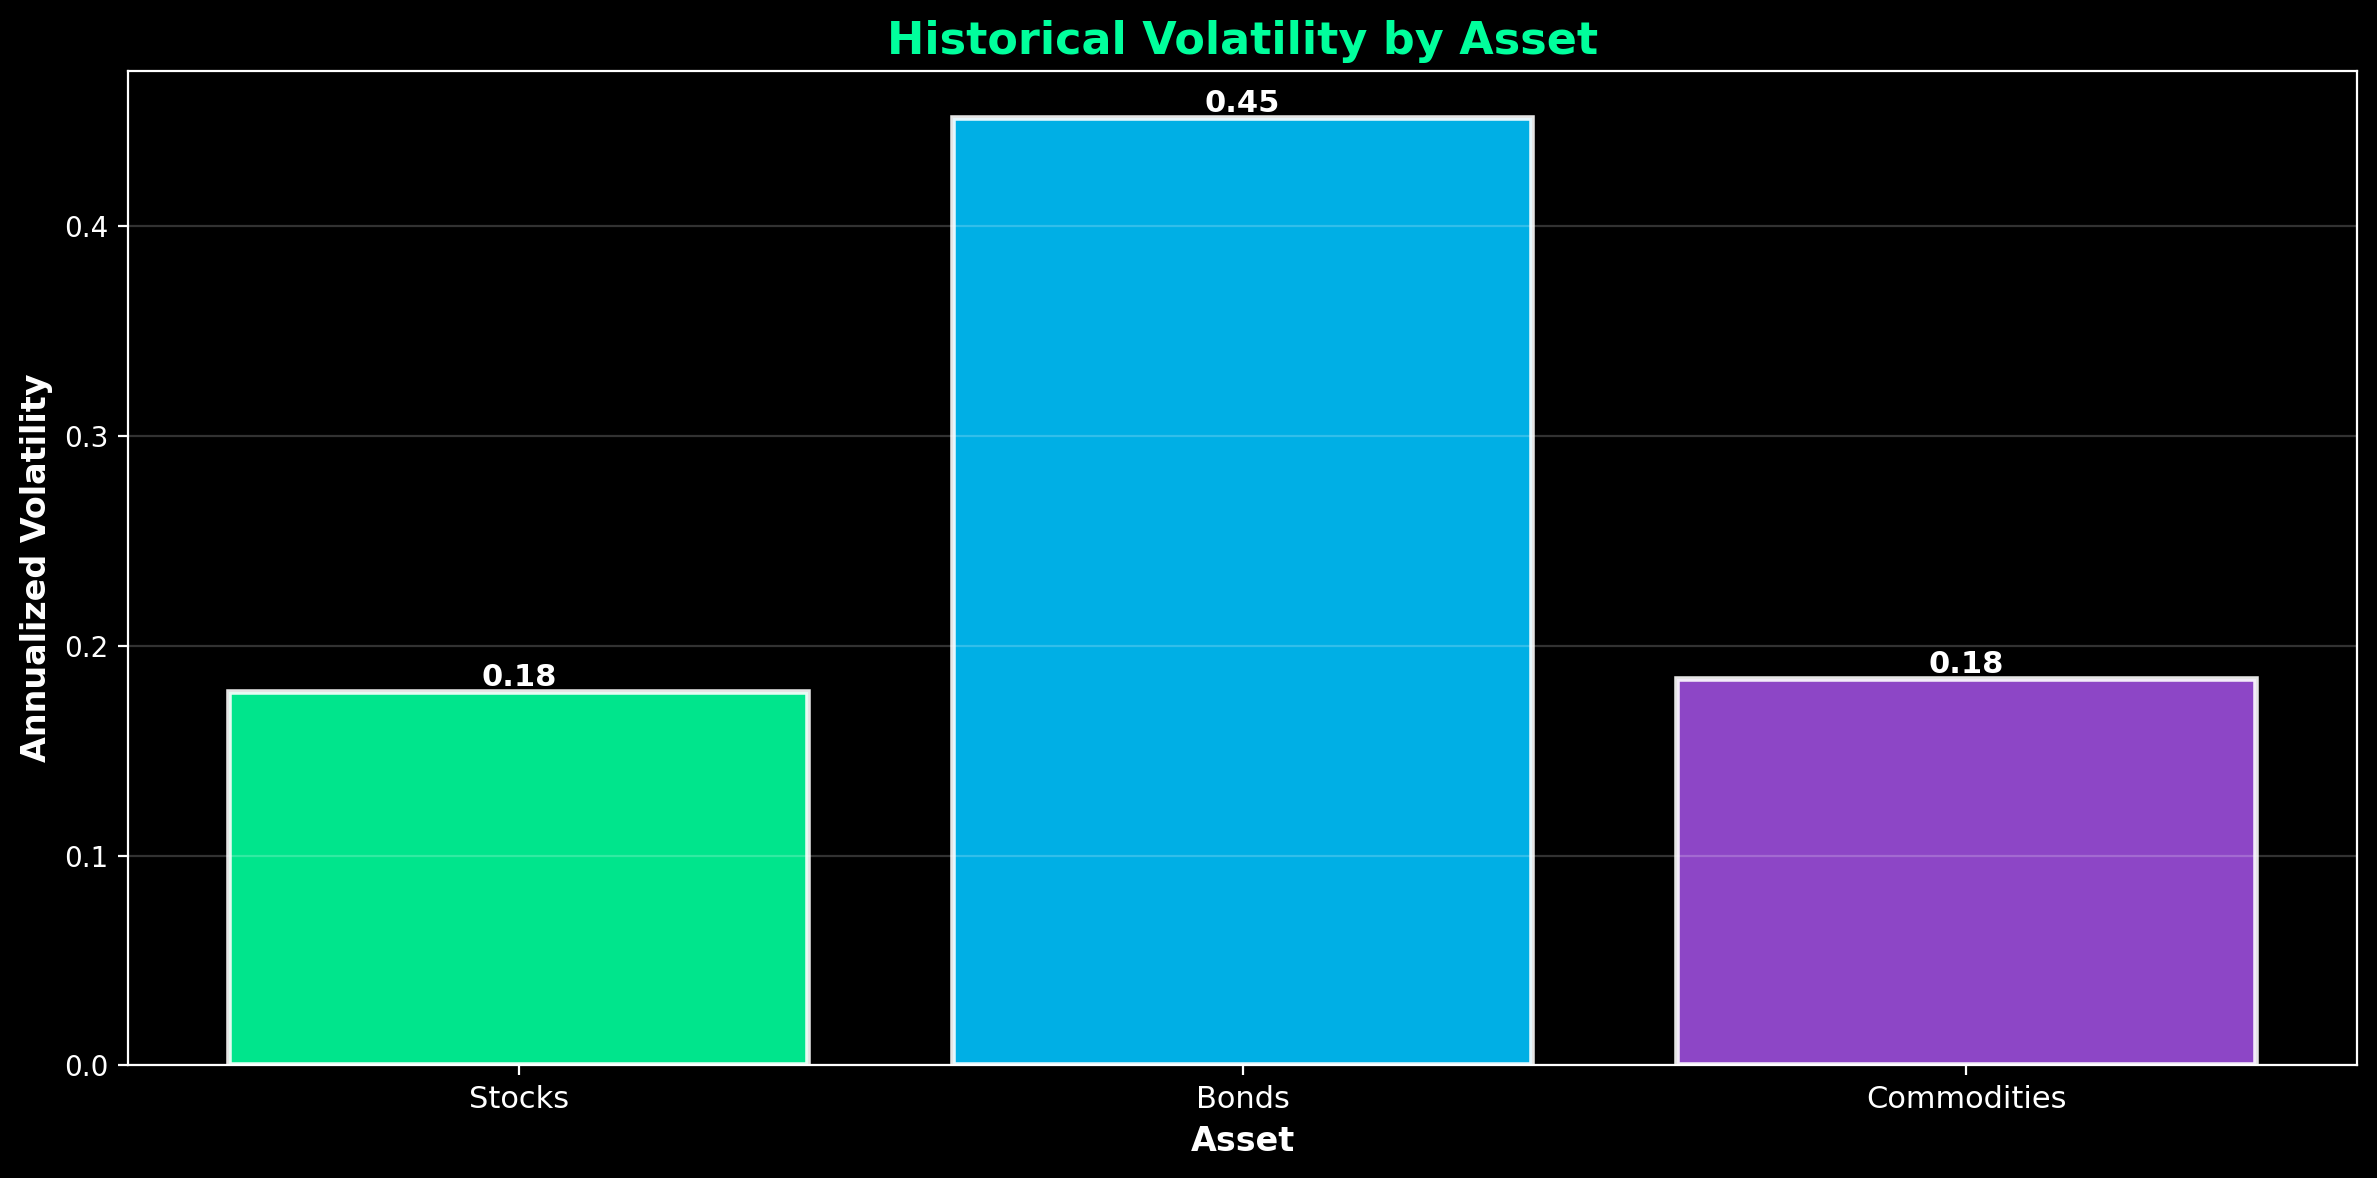

In [34]:
# Bar chart of volatilities
STONKS_PALETTE = ['#00ff9c', '#00c3ff', '#9d4edd', '#ffbe0b', '#fb5607']

fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(historical_vol))
bars = ax.bar(x, historical_vol, 
             color=STONKS_PALETTE,
             edgecolor='white', linewidth=2, alpha=0.9)

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
           f'{height:.2f}',
           ha='center', va='bottom', 
           fontsize=11, fontweight='bold', color='white')

ax.set_xlabel('Asset', fontsize=12, fontweight='bold', color='white')
ax.set_ylabel('Annualized Volatility', fontsize=12, fontweight='bold', color='white')
ax.set_title('Historical Volatility by Asset', 
            fontsize=16, fontweight='bold', color=STONKS_GREEN)
ax.set_xticks(x)
ax.set_xticklabels(historical_vol.index, fontsize=11)
ax.grid(True, alpha=0.2, axis='y')

plt.tight_layout()
plt.show()

## 7. Key Insights

In [36]:
# Summary statistics
print("\n🔍 KEY INSIGHTS:")
print("=" * 60)

# Most volatile asset
most_volatile = historical_vol.idxmax()
print(f"\n📊 Most Volatile Asset: {most_volatile} ({historical_vol.max():.2%})")

# Least volatile asset
least_volatile = historical_vol.idxmin()
print(f"📊 Least Volatile Asset: {least_volatile} ({historical_vol.min():.2%})")

# Highest correlation pair
corr_no_diag = corr_matrix.where(~np.eye(len(corr_matrix), dtype=bool))
max_corr = corr_no_diag.max().max()
max_corr_pair = corr_no_diag.stack().idxmax()
print(f"\n🔗 Highest Correlation: {max_corr_pair[0]} & {max_corr_pair[1]} ({max_corr:.3f})")

# Lowest correlation pair
min_corr = corr_no_diag.min().min()
min_corr_pair = corr_no_diag.stack().idxmin()
print(f"🔗 Lowest Correlation: {min_corr_pair[0]} & {min_corr_pair[1]} ({min_corr:.3f})")

print("\n" + "=" * 60)


🔍 KEY INSIGHTS:

📊 Most Volatile Asset: Bonds (45.15%)
📊 Least Volatile Asset: Stocks (17.79%)

🔗 Highest Correlation: Stocks & Bonds (0.281)
🔗 Lowest Correlation: Bonds & Commodities (0.028)



## Summary

**Key Findings**:
- Asset volatilities vary significantly (important for risk parity!)
- Correlations show diversification opportunities
- Volatility spikes during crisis periods (especially COVID)
- Traditional 60/40 would be dominated by equity risk

**Why This Matters for Risk Parity**:
- Equal capital allocation ≠ Equal risk allocation
- Need to adjust weights based on volatility
- Goal: Each asset contributes equally to portfolio risk

**Next Steps**:
- Notebook 03: Optimize risk parity portfolio
- Notebook 04: Compare against benchmarks